In [1]:
#Importing the librairies

import os
import tarfile
import urllib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

#Only for jupyter notebooks
%matplotlib inline

pd.set_option('mode.chained_assignment', None)

https://github.com/ageron/handson-ml2/blob/master/math_linear_algebra.ipynb

## The normal equation

In [2]:
X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)

[]

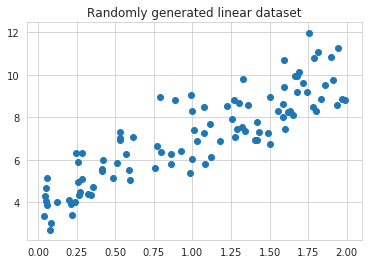

In [3]:
plt.scatter(x=X,y=y)
plt.title("Randomly generated linear dataset")
plt.plot()

... Computing the value of that minimizes the cost function using the normal equation...

In [4]:
X_b = np.c_[np.ones((100,1)),X] #add x0 = 1 to each instance

theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [5]:
theta_best

array([[4.06397348],
       [2.98464143]])

Close enought to the 4 + 3 + gaussian noise.

In [6]:
#We can now make predictions using the theta_best.

X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)),X_new] #Add x0=1 to each instance
y_predict = X_new_b.dot(theta_best)

print(y_predict)

[[ 4.06397348]
 [10.03325635]]


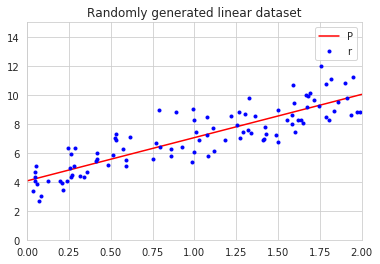

In [7]:
plt.plot(X_new,y_predict,"r-")
plt.plot(X,y,"b.")
plt.axis([0,2,0,15])
plt.title("Randomly generated linear dataset")
plt.legend("Prediction")

In [8]:
#Doing it with Sklearn is simple...

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X,y)
print(lin_reg.intercept_,lin_reg.coef_)
print("\n")
print(lin_reg.predict(X_new))

[4.06397348] [[2.98464143]]


[[ 4.06397348]
 [10.03325635]]


In [9]:
#Same same as scikit learn is based on scipy linalg lstsq (least square)
theta_best_svd,residuals,rank,s = np.linalg.lstsq(X_b,y,rcond=1e-6)
print(theta_best_svd)

[[4.06397348]
 [2.98464143]]


In [10]:
#The function computes the pseudo inverse of X, X^+(theta_best = X^+ * y). Possible to get it also with np.linalg.pinv()
np.linalg.pinv(X_b).dot(y)

array([[4.06397348],
       [2.98464143]])

The pseudoinverse itself is computed using a standard matrix factorization technique called *Singular Value Decomposition*(SVD).
The SVD approach used by Scikit-Learn's LinearRegression class is about O(n^2). If you double the number of features, you multiply the computation time by roughly 4.

## Gradient descend

It's a generic optimization algorithm capable of finding optimal solution. The general idea is to tweak parameters iteratively in order to minimize a cost function. Once the gradient is zero, the minimun is reached.

Concretely, you start by filling theta with random values (*random initialization*) then you improve it gradually, taking one baby step at the time, each step attempting to decrease the cost function, until the algorithm converges to a minimum.

An important parameter is the size of the steps, determined by the learning rate hyperparameter.If too small, then the algorithm may have to go through many iterations to converge, which will take a long time. On the other hand, if too high, it might jump accross the valley and make the algorithm diverge, with larger and larger values, failing to find a good solution.

Two main challenges:
* Converging in a local minimum instead of a global minimum
* Crossing plateau in case of flat curve which will make it never reach the global minimum if stopped too early.

With MSE for LinearRegression, there's only one global minimum, not local ones because the function is a convex function, and since it's a continuous function, the slope won't change abruptly.

## Batch Gradient Descent

To implement Gradient Descent, it is needed to compute the gradient of the cost function with regard to each model parameter thetaj. In other words, we need to calculate how much the cost function will change if you change thetaj a little bit. It's called *Partial derivative*. The gradient vector contains all the partial derivatives of the cost function (one for each model parameter).

In [11]:
eta = 0.1 #Learning Rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [12]:
theta

array([[4.06397348],
       [2.98464143]])

A solution about how to find the good number of iterations is to se a very large number but to interrupt the algorithm when the gradient vector becomes tiny (when its norm becomes smaller than a tiny number e (called tolerance)) because this happens when gradient descent has (almost) reached the minimum.

## Stochastic Gradient Descent

As opposite with Batch Gradient Descent, Stochastic Gradient Descent picks a random instance in the training set at every step and computes the gradients based only on that single instance (much faster than Batch Gradient Descent and can be implemented as out-of-core algorithm).

On the other hand, this algorithm is much less regular than batch gradient descent. Because it is always bouncing back and fourth,when it stops, the final parameter values are good,but not optimal. But when the cost function is very irregular, this can actually help the algorithm jump out out of a local minima, so Stochastic Gradient Descent has a better chance of finding the global minimum than Batch Gradient Descent does.

Randomness is good to escape from local optima but bad because it means that the algorithm can never settle at the minimum. One solution to this dilemma is to gradually reduce the learning rate. This is called *simulated annealing*, where the steps start out large (to escape local mimimum) and then gets smaller and smaller allowing the algorithm to settle at the global minimum. The function that determines the learning rate at each iteration is called the *learning schedule*.

In [13]:
n_epochs = 50
t0,t1 = 5, 100

In [14]:
def learning_schedule(t):
    return t0 / (t + t1)

In [15]:
thetha = np.random.randint(1,2) #Random Initialization

In [16]:
for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + 1)
        theta = theta - eta * gradients

In [17]:
theta

array([[4.09506506],
       [3.0013409 ]])

If we want to be sure that the algorithm goes to through every instance at each epoch, another approach is to to shuffle the training set (making sure to shuffle the input features and the labels jointly), then go through it instance by instance, then shuffle it again, and so on. However, this approach generally converges more slowly.

/!\ While using SGD, the training instances must be independent and identically to ensure that the parameters get pulled toward the global optimum, on average. A simple way to ensure this is to shuffle the instances during training (e.g. pick each instance randomly, or shuffle the training set at the beginning at each epoch). If it's not done, then SGD will start to optimize for one label, then the next and so on and will not converge to the global minimum.

In [18]:
from sklearn.linear_model import SGDRegressor

In [19]:
sgd_reg = SGDRegressor(max_iter=1000,tol=1e-3,penalty=None,eta0=0.1) #learning rate at 0.1 default learning schedule, no regulatization and stops if loss drops by less than 0.001 during one epoch
sgd_reg.fit(X,y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [20]:
sgd_reg.intercept_,sgd_reg.coef_

(array([4.01434619]), array([2.95888815]))

## Mini-Batch Gradient Descent

At each step, instance of computing the gradients based n the full training set (as in Batch GD) or based on just one instance (as in Stochastic GD), mini-batches GD computes the gradients on small random sets of instances called mini-batches. The main advantage of mini-batches vs Stochastic GD is the performance boost from hardware optimization of matrix operations (especially with GPUs).

The algorithm's process in parameter space is less erratic than with Stochastic GD (especially with fairly large mini-batches). As a result, Mini-Batches SG will end up walking closer to the global minimum than Stochastic GD but it may be harder for it to escape from local minima (in the case of problems that suffer from local minima, unlike LinearRegression). It is important to use a good learning schedule though as they will both walk around the global minimum.

## Polynomial Regression

Polynomial Regression is a technique allowing us to fit nonlinear data with a linear model by adding powers of each feature as new features.

In [21]:
m = 100
X = 6 * np.random.rand(m,1) - 3
y = 0.5 * X**2 + X + 2 + np.random.rand(m,1)

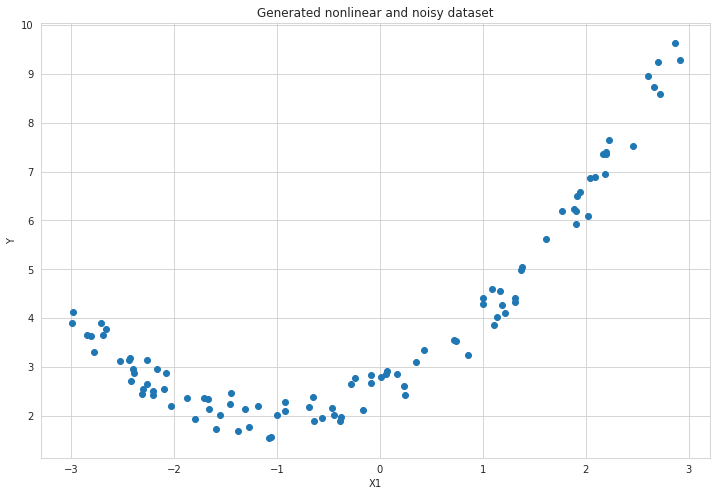

In [22]:
plt.figure(figsize=(12,8))
plt.scatter(X,y)
plt.title("Generated nonlinear and noisy dataset")
plt.xlabel("X1")
plt.ylabel("Y")
plt.show()

In [23]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2,include_bias=False)
X_poly = poly_features.fit_transform(X)

In [24]:
X[0],X_poly[0] #X_poly contains the original feature and the square of it.

(array([-2.0951809]), array([-2.0951809 ,  4.38978301]))

In [25]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly,y)
lin_reg.intercept_,lin_reg.coef_

(array([2.52438427]), array([[1.01548497, 0.49936791]]))

In [26]:
y_poly = lin_reg.predict(X_poly)
X_poly, y_poly = zip(*sorted(zip(X, y_poly)))

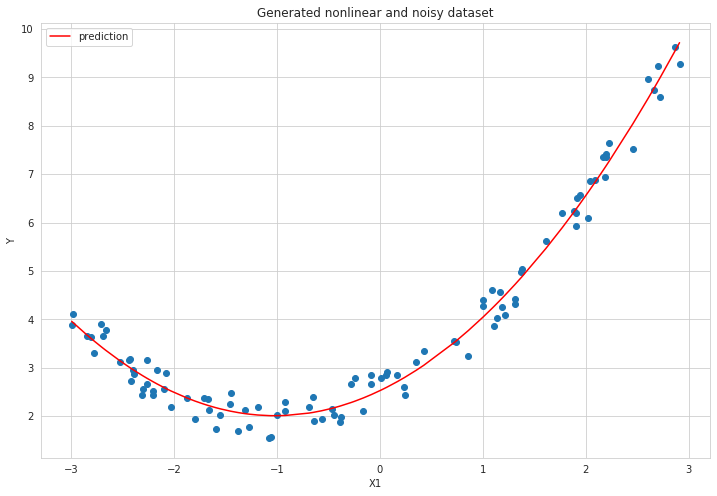

In [27]:
plt.figure(figsize=(12,8))
plt.scatter(X,y)
plt.plot(X_poly, y_poly,"r",label="prediction")
plt.title("Generated nonlinear and noisy dataset")
plt.xlabel("X1")
plt.ylabel("Y")
plt.legend()
plt.show()

Polynomial Regression is capable of finding relationships between features. It is possible by the fact that PolynomialFeatures also adds all combinations of features up to the given degree. For example, if there were two features a and b, and PolynomialFeatures with degree=3, then it would add not only a2, a3, b2 and b3 but also ab, a2b and ab2.

/!\ PolynomialFeatures(degree=d) transforms an array containing n features into an array containing (n + d)! / d!n! --> Be careful of the explosion of the number of features!

## Learning curve

In [28]:
poly_features_1 = PolynomialFeatures(degree=1,include_bias=False)
X_poly_1 = poly_features_1.fit_transform(X)
lin_reg.fit(X_poly_1,y)
y_poly_1 = lin_reg.predict(X_poly_1)
X_poly_1, y_poly_1 = zip(*sorted(zip(X, y_poly_1)))

In [29]:
poly_features_30 = PolynomialFeatures(degree=30,interaction_only=False)
X_poly_30 = poly_features_30.fit_transform(X)
lin_reg.fit(X_poly_30,y)
y_poly_30 = lin_reg.predict(X_poly_30)
X_poly_30, y_poly_30 = zip(*sorted(zip(X, y_poly_30)))

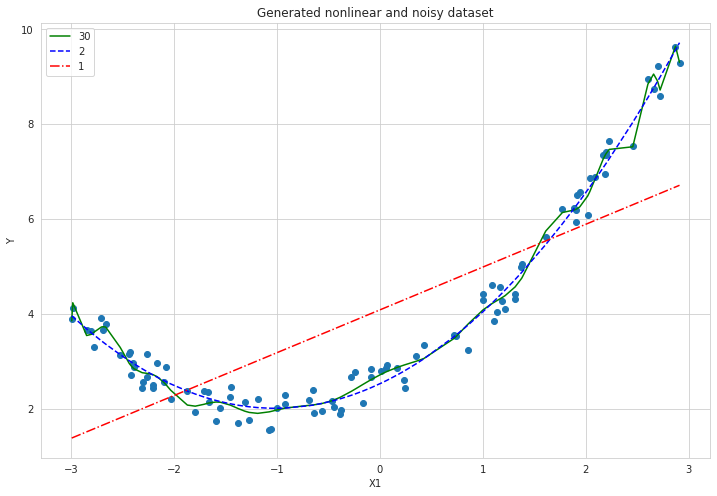

In [30]:
plt.figure(figsize=(12,8))
plt.scatter(X,y)
plt.plot(X_poly_30,y_poly_30,"g",label="30")
plt.plot(X_poly, y_poly,"b",linestyle="--",label="2")
plt.plot(X_poly_1,y_poly_1,"r",label="1",linestyle="-.")
plt.title("Generated nonlinear and noisy dataset")
plt.xlabel("X1")
plt.ylabel("Y")
plt.legend()
plt.show()

In [31]:
#We can clearly see that degree=30 is overfitting while degree=1 is underfitting!

**Learning curve**: plot that shows the model performance on the training set and the validation set as a function of the training set size (or the training iteration).

In [32]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [33]:
def plot_learning_curve(model,X,y):
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    train_errors,val_erros = [],[]
    for m in range(1,len(X_train)):
        model.fit(X_train[:m],y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m],y_train_predict))
        val_erros.append(mean_squared_error(y_val,y_val_predict))
        
    plt.figure(figsize = (12,6))    
    plt.plot(np.sqrt(train_errors),"r-+",linewidth = 2, label = "train")
    plt.plot(np.sqrt(val_erros), "b-",linewidth = 3, label = "val")
    plt.legend()
    plt.ylim(-0.1,5)
    plt.xlabel("Training Set Size")
    plt.ylabel("RMSE")
    plt.title("Learning curves")

In [34]:
lin_reg = LinearRegression()

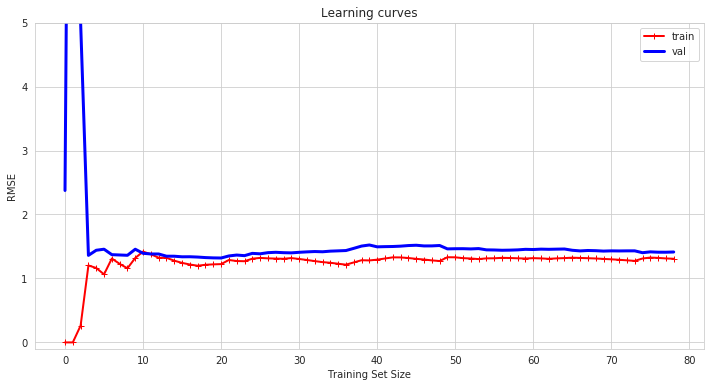

In [35]:
plot_learning_curve(lin_reg,X,y)

The model is clearly underfitting. The curve starts at zero because with one or two instance, the model fits perfectly.
But when new instances are added to the training set, it becomes impossible for the model to fit new training data perfectly and finally reaches a plateau. On the opposite, on the validation data, the model is trained on very few data and it's incapable of generalizing properly, which is why the validation error is high. After that, when new validation data are added, the validation error goes down but like the training error,reaches a plateau which is very close to the training error.

These learning curves are typical of a model that's underfitting. Both curves have reached a plateau,by being close and fairly high.

If a model is underfitting the training data, a more complex model or better features are needed because adding more training data won't help.

In [36]:
from sklearn.pipeline import Pipeline

In [37]:
polynomial_regression = Pipeline([
    ("poly_feature",PolynomialFeatures(degree=10,include_bias=False)),
    ("lin_reg",LinearRegression()),])

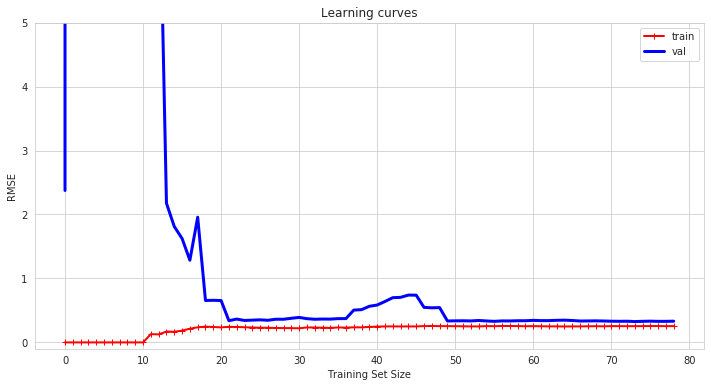

In [38]:
plot_learning_curve(polynomial_regression,X,y)

Difference between this one and the previous one:
   * The error on the training data is lower.
   * The gap between the validation error and the training error means that the model performs better on the training data than on the validation data which is a sign of overfitting. Adding more training data will get the two curves closer.
   
One way to improve an overfitting model is to feed it more training data until the validation error reaches the training error.

### The Bias/Variance Tradeoff:
* Bias: This part of generalization error is due to the wrong assomptions (like the model being linear when it's quadratic). A high-bias model is most likely to underfit the training data.

* Variance: This part is due to the model's excessive sensitivity to small variations in the training data. A model with many degrees of freedom is likely to have high varianceand thus overfit the training data.

* Irreducble error: This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data.

Increasing a model's complexity will typically increase its variance and reduce its bias. Decreasing a model's complexity will reduce its variance but will increase its bias. Therefore the name trade-off.

## Regularized Linear Models

For a linear model, regularization is typically achieved by constraining the weights of the model.

### Ridge Regression

It's a regularized version of Linear Regression with a regularization term  added to the cost function. This forces the learning algorithm to not only fit the data but also to keep the model weights as small as possible.

/!\ Note : The regularization term should only be added to the cost function during training. Once the model is trained, you want to use unregularized performance measure to evaluate the model's performance. This is due to that a good training cost function should have optimization-friendly derivatives, while the performance measure used for testing should be as close as possible to the final objective.

The hyperparameter alpha controls how much you want to regularize the model. If alpha = 0, then it's just a linear regression, and if alpha is huge, then all the weights end up close to zero and the result is a flat line going through the data's mean.

/!\ It is important to scale the data before performing the Ridge Regression, as it is sensitive to the scale of the input features. This is true to most regularized models.

In [39]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1,solver="cholesky")
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[5.43085891]])

In [40]:
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X,y)
sgd_reg.predict([[1.5]])

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([5.40462167])

### Lasso Regression (*Least Absolute Shrinkage and Selection Operator Regression*)

Just like Ridge Regression, it adds a regularization term to the cost function, but it uses the l1 norm of the weight vector instead of half the square of the l2 norm.

An important characteristic of Lasso Regression is taht it tends to eliminate the weights of the least important features(by setting them to zero). It automatically performs feature selection and outputs a sparse model (with few nonzero feature weights).

To avoid Gradient Descent from boucing around the optimum at the end when using Lasso, you need to gradually reduce the learning rate during training (it will bounce around the optimum, but the steps will get smaller and smaller, so it will converge).

In [41]:
from sklearn.linear_model import Lasso

Lasso_reg = Lasso(alpha=0.1)
Lasso_reg.fit(X,y)
Lasso_reg.predict([[1.5]])

array([5.38081909])

In [42]:
sgd_reg = SGDRegressor(penalty="l1")
sgd_reg.fit(X,y)
sgd_reg.predict([[1.5]])

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([5.40300782])

### ElasticNet

ElasticNet is a middle ground between Ridge Regression and Lasso Regression with a regularization term being a mix between of both Ridge and Lasso's regularization terms, that can be controled with the term r. If r=0, then it's a Ridge Regression, and if r=1, it's a Lasso Regression.

**/!\** It is always preferable to have at least a bit of regularization, so we should avoid plain Linear Regression. Ridge is a good default, but if you suspect that only a few features are useful, we should prefer Lasso or ElasticNet regression because they tend to reduce useless features's weights to zero. In general, ElasticNet is preferred over Lasso because Lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated.

In [43]:
from sklearn.linear_model import ElasticNet

ElasticNet_reg = ElasticNet(alpha= 0.1,l1_ratio=0.5)
ElasticNet_reg.fit(X,y)
ElasticNet_reg.predict([[1.5]])

array([5.38432146])

## Early Stopping

A very different way to regularize iterative learning algorthms such as Gradient Descent is to stop training as soon as the validation error reaches a minimum. This is called Early Stopping.

With stochastic and mini-batch Gradient Descent, the curves are not so smooth, and it may hard to know whether you have reached the minimum or not. One solution is to stop only after the validation error has been above the minimum for some time, then roll back the model parameters to the point where the validation error was at the minimum.

In [44]:
from sklearn.base import clone

In [45]:
from sklearn.preprocessing import StandardScaler

In [46]:
#Preparing the data

poly_scaler = Pipeline([
    ("poly_features",PolynomialFeatures(degree=90,include_bias=False)),
    ("std_scaler",StandardScaler())
])

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
#Transforming the data (polynomial features and )
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

In [49]:
#The model, when warm_start is true, the model continues the train where it was left off instead of retraining from scratch.
sgd_reg = SGDRegressor(max_iter=1,tol=-np.infty,warm_start=True,penalty=None,learning_rate="constant",eta0=0.0005)

In [50]:
minimum_val_error = float("inf")
best_epoch = None
best_model = None

In [51]:
for epoch in range(1000):
    
    sgd_reg.fit(X_train_poly_scaled,y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val,y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

In [52]:
print(best_model)
print(best_epoch)
print(minimum_val_error)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=1,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=None,
             shuffle=True, tol=-inf, validation_fraction=0.1, verbose=0,
             warm_start=True)
945
0.08550249646130399


## Logistic Regression

### Estimating Probabilities

Just like a Linear Regression model, a Logistic Regression model computes a weighted sum of the input features (plus a bias term), but instead of outputting the result directly like the Linear Regression does, it outputs the logistic of this result.

The logitic is a sigmoid function that outputs a number between 0 and 1. It is defined as 

lambda(t) = 1 / 1 + exp^(-t)

The score t is often called the logit. The name comes from the fact that this inverse of the logistic function, and if we compute the logit of the estimated probability of p, we will find the result t. The logit is also called log-odds, since it is the log of the ratio between the estimated probability for the positive class and the estimated probability for the negative class.

### Training and cost function

The cost function over the whole training set is the average cost over all training instances. It can be written in a single expression called the log loss.

The cost function is convex so Gradient Descent and any other optimization algorithm is guaranteed to find the global minimum (if the learning rate is not too large and you wait long enough).

### Decision boudaries

In [53]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [54]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [55]:
X = iris["data"][:,3:] #Pedal width only
y = (iris["target"] == 2).astype(np.int) # 1 if Iris virginica, else 0

In [56]:
from sklearn.linear_model import LogisticRegression

In [57]:
log_reg = LogisticRegression()
log_reg.fit(X,y)

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [58]:
X_new = np.linspace(0,3,1000).reshape(-1,1) # Creating petal width from 0 to 3 cm

y_proba = log_reg.predict_proba(X_new)

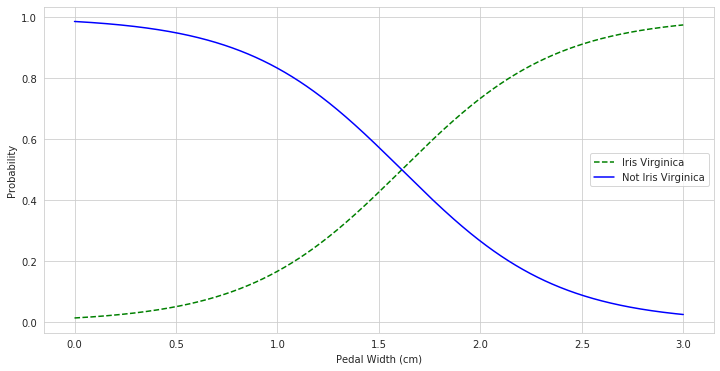

In [59]:
plt.figure(figsize=(12,6))
plt.plot(X_new,y_proba[:,1],"g--",label="Iris Virginica")
plt.plot(X_new,y_proba[:,0],"b-",label="Not Iris Virginica")
plt.xlabel("Pedal Width (cm)")
plt.ylabel("Probability")
plt.legend()
plt.show()

There is a decision boudary at around 1.6cm where both probabilities are equal to 50%. If it's higher, the algorithm will predict that the flower is an Iris Virginica, otherwise it will predict that is not.

## Softmax Regression

The logistic Regression model can be generalized to support multiple classes directly, without having to train and combine multiple binary classifier. This is called Softmax Regression, or Multinomial Logistic Regression.

When given an instance x, the Softmax Regression model first computes a score sk(x) for each class k, then estimates the probability of each class by applying the softmax function (also called the normalized exponential).

Just like the Logistic Regression, the Softmax Regression classifier predicts the class with the highest estimated probability (which is simply the class with the highest score).

The Softmax Regression classifier predicts only one class at a time (multiclass =/= multioutput) so it should be used only with mutually exclusive classes, sucha as different types of plants. It cannot be used to recognize multiple people in one picture for instance.

The cost function for the Softmax Regression is called *Cross Entropy*. The objective is to have a model that estimates a high probability for the target class and a low probability for the other classes.

Cross entropy is frequently used to measure how well a set of estimated class probabilities matches the target classes.

In [60]:
X = iris["data"][:,(2,3)]
y = iris["target"]

In [61]:
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs",C=10)
softmax_reg.fit(X,y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [62]:
softmax_reg.predict([[5,2]])

array([2])

In [63]:
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

The decision boundaries between two classes are linear. It has to be noticed that the model can predict a class that has an estimated probability below 50%.

## Exercices

1. Which Linear Regression training algorithm can you use if you have a training set with millions of features?
    * We can use Lasso Regression algorithm to do some feature selection (because the algorithm will put useless features' weight to zero). We can also use ElasticNet which is a mix between Lasso Regression and Ridge Regression.
    
    
2. Suppose the features in your training set have very different scales. What algorithms might suffer from this, and how? What can you do about it?
    * Every regularized algorithm will suffer from having data with different scales because they are sensitive to the scale of the input features. They will behave erractly by removing or reducing / increasing the weights of those features. What we can do about it is to standardize or normalize the data.
    
    
3. Can Gradient Descent get stuck in a local minimum when training a Logistic Regression model?
    * Gradient Descent cannot get stuck in a local minimum because the Logistic Regression model cost function is convex, and will reach directly the global minimum.
    

4. Do all Gradient Descent algorithms lead to the same model provided you let them run long enough?
    * They will all converge towards the global minimum even though mini-batch GB and Stochastic GB will bounce around it. Only Batch Gradient reach the global minimum.
    

5. Suppose you use Batch Gradient Descent and you plot the validation error at every epoch. If you notice that the validation error consistently goes up, what is likely going on? How can you fix this?
    * if the validation error goes up at every epoch, we are more likely to be overfitting the training data and therefore our model is not capable of generalizing correctly. We can fix this by adding more training data which will bring the validation and training error closer.
    

6. Is it a good idea to stop Mini-batch Gradient Descent immediately when the validation error goes up?
    * No because it could be that the algorithm is getting out of a local minimum to reach the global minimum.
    

7. Which Gradient Descent algorithm (among those we discussed) will reach the vicinity of the optimal solution the fastest? Which will actually converge? How can you make the others converge as well?
    * The Stochastic Gradient Descend is the one reaching the vicinity of the optimal solution the fastest, but will just converge like the Mini-Batch GD whereas the Batch GD will reach the global minimum. One solution to make them converge towards the global minimum is using a technique called *Simulated annealing* or learning Schedule where with start with a high learning rate and we reduce it little by little.
    

8. Suppose you are using Polynomial Regression. You plot the learning curves and you notice that there is a large gap between the training error and the validation error. What is happening? What are three ways to solve this?
    * We are experiencing overfitting. The three ways to solve this are: Regularization, more training data and early stopping.
    

9. Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter α or reduce it?
    * By having a training and validation error almost equal and fairly we can say that the model is underfitting and suffers from a high bias and a low variance. To reduce the the high bias, we should reduce the regularization hyperparameter.
    

10. Why would you want to use:
    * Ridge Regression instead of Linear Regression? It's always better to use a bit of regulation than nothing (ridge versus linear)
    * Lasso instead of Ridge Regression? When we have a high number of features and we want to withdraw the useless features.
    * Elastic Net instead of Lasso? When we have a hyperparametric dataset (more features than observations) because Lasso may behave erratically or when the features are strongly correlated.
    

11. Suppose you want to classify pictures as outdoor/indoor and daytime/nighttime. Should you implement two Logistic Regression classifiers or one Softmax Regression classifier?
    * Since Softmax Regression classifier doesn't do multilabelling, we should use two logisitc regression classifiers since outdoor/indoor and daytime/nighttime are not mutually exclusive.


12. Implement Batch Gradient Descent with early stopping for Softmax Regression (without using Scikit-Learn).

In [93]:
#Exercice 12

from sklearn.metrics import log_loss

X = iris["data"] 
y = iris["target"]


scaler = Pipeline([
#("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
("std_scaler", StandardScaler())
])


X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.3,random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs",C=10,warm_start=True)

minimum_val_error = float("inf")
best_epoch = None
best_model = None

i = 0

for epoch in range(1000):
    
    softmax_reg.fit(X_train,y_train)
    y_val_predict = softmax_reg.predict_proba(X_val)
    val_error = log_loss(y_val,y_val_predict)
    
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(softmax_reg)
        
    elif val_error >= minimum_val_error:
        i +=1
        if i == 3:
            break
    
    
        
print(best_model)
print(best_epoch)
print(minimum_val_error)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=True)
0
0.034970222759695496


/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [92]:
i

3